In [36]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm


from connect4.connect_state import ConnectState
from connect4.policy import Policy

from policy import SmartMCTS

from groups.GroupA.policy import Aha
from groups.GroupB.policy import Hello
from groups.GroupC.policy import OhYes
from groups.GroupG.policy import ClaimEvenPolicy
from groups.GroupF.policy import MinimaxPolicy
from groups.GroupE.policy import AllisPolicy



In [37]:
def play_game(policy_red: Policy, policy_yellow: Policy, render=False):
    state = ConnectState()
    policies = {-1: policy_red, 1: policy_yellow}

    while not state.is_final():
        p = state.player
        action = policies[p].act(state.board)

        if not state.is_applicable(action):
            # Illegal move loses
            return -p
        
        state = state.transition(action)
        
        if render:
            print(state.board)
            print("---------------")

    return state.get_winner()


In [38]:
def evaluate(red_policy_class, yellow_policy_class, n_games=5, desc=None):
    results = { "red": 0, "yellow": 0, "draw": 0 }

    iterator = range(n_games)
    if desc is not None:
        iterator = tqdm(iterator, desc=desc, leave=False)

    for i in iterator:
        red = red_policy_class()
        yellow = yellow_policy_class()
        red.mount()
        yellow.mount()

        w = play_game(red, yellow)
        if w == -1:
            results["red"] += 1
        elif w == 1:
            results["yellow"] += 1
        else:
            results["draw"] += 1

    return results


In [ ]:
policies = {
    "SmartMCTS": SmartMCTS,
    "Claimeven": ClaimEvenPolicy,
    "Allis": AllisPolicy,
    "Minimax": MinimaxPolicy,
    "OhYes": OhYes,
    "Hello": Hello,
    "Aha": Aha
}

results_matrix = {}

with tqdm(total=5, desc="Simulaciones totales") as pbar:
    for nameA, polA in policies.items():
        for nameB, polB in policies.items():
            print(f"Simulando: {nameA} (Rojo) vs {nameB} (Amarillo)...")
            results = evaluate(polA, polB, n_games=6)
            results_matrix[(nameA, nameB)] = results

            matchup_desc = f"{nameA} (Rojo) vs {nameB} (Amarillo)"
            results = evaluate(polA, polB, n_games=6, desc=matchup_desc)
            results_matrix[(nameA, nameB)] = results

            pbar.update(1)


Simulaciones totales:   0%|          | 0/5 [00:00<?, ?it/s]

Simulando: SmartMCTS (Rojo) vs SmartMCTS (Amarillo)...


Simulaciones totales:   0%|          | 0/5 [08:39<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import pandas as pd

data = []
for (pA, pB), res in results_matrix.items():
    row = {
        "Red": pA,
        "Yellow": pB,
        "RedWins": res["red"],
        "YellowWins": res["yellow"],
        "Draws": res["draw"]
    }
    data.append(row)

df = pd.DataFrame(data)
df


,Red,Yellow,RedWins,YellowWins,Draws
0,SmartMCTS,SmartMCTS,30,27,3
1,SmartMCTS,Claimeven,60,0,0
2,SmartMCTS,Allis,20,39,1
3,Claimeven,SmartMCTS,1,59,0
4,Claimeven,Claimeven,31,29,0
5,Claimeven,Allis,0,60,0
6,Allis,SmartMCTS,36,21,3
7,Allis,Claimeven,60,0,0
8,Allis,Allis,36,24,0


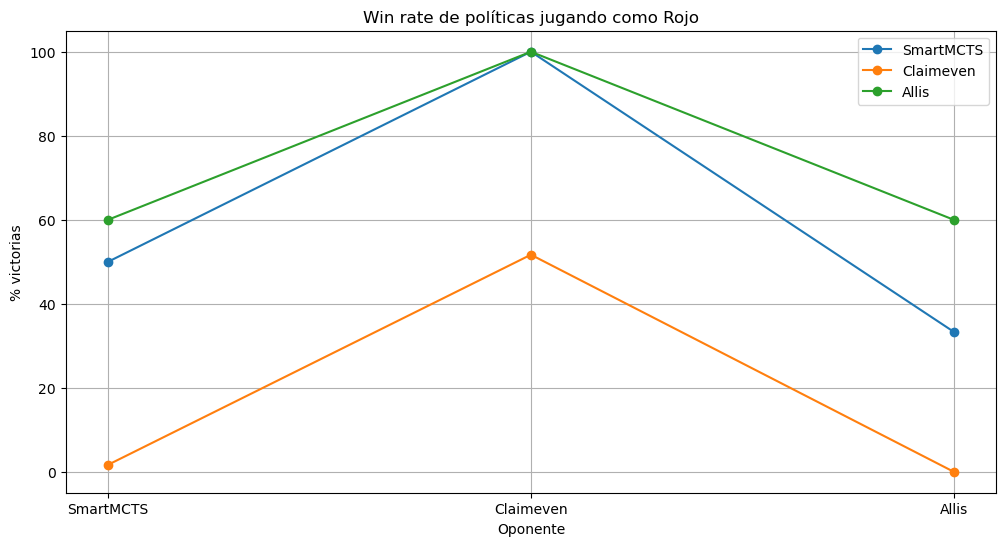

In [ ]:
plt.figure(figsize=(12,6))

for pol in policies.keys():
    winrates = []
    rivals = []
    for rival in policies.keys():
        res = results_matrix[(pol, rival)]
        total = res["red"] + res["yellow"] + res["draw"]
        winrates.append(100 * res["red"] / total)
        rivals.append(rival)

    plt.plot(rivals, winrates, marker="o", label=pol)

plt.title("Win rate de políticas jugando como Rojo")
plt.ylabel("% victorias")
plt.xlabel("Oponente")
plt.legend()
plt.grid(True)
plt.show()


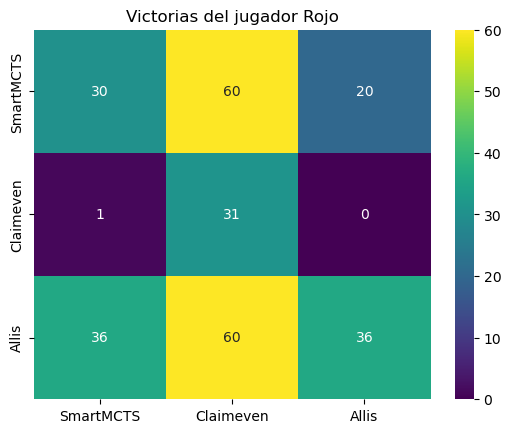

In [ ]:
import seaborn as sns

matrix = np.zeros((3,3))

names = list(policies.keys())

for i,pA in enumerate(names):
    for j,pB in enumerate(names):
        matrix[i,j] = results_matrix[(pA,pB)]["red"]

sns.heatmap(matrix, annot=True, xticklabels=names, yticklabels=names, cmap="viridis")
plt.title("Victorias del jugador Rojo")
plt.show()


In [ ]:
class MCTSNodeK:
    def __init__(self, state: np.ndarray, player: int, parent=None, action=None):
        self.state = state
        self.player = player  # jugador que ACABA de mover
        self.parent = parent
        self.action = action  # acción que llevó a este estado
        self.children = []
        self.visits = 0
        self.wins = 0  # desde la perspectiva del jugador raíz

    def is_fully_expanded(self, legal_moves: list[int]) -> bool:
        return len(self.children) == len(legal_moves)

    def best_child(self, c_param: float, k_factor: float) -> "MCTSNodeK":
        """
        UCT: (wins/visits) + c * sqrt( K * log(N) / n )
        donde K = k_factor (antes K=2 fijo).
        """
        choices_weights = []
        for child in self.children:
            exploit = child.wins / child.visits
            explore = math.sqrt(
                (k_factor * math.log(self.visits)) / child.visits
            )
            choices_weights.append(exploit + c_param * explore)

        return self.children[np.argmax(choices_weights)]

    def expand(self, action: int, new_state: np.ndarray, next_player: int) -> "MCTSNodeK":
        child = MCTSNodeK(new_state, next_player, self, action)
        self.children.append(child)
        return child


In [ ]:
class SmartMCTS_K(Policy):
    def __init__(self, iterations: int = 200, c_param: float = 1.414, k_factor: float = 2.0):
        self.iterations = iterations
        self.c_param = c_param
        self.k_factor = k_factor  # AQUÍ probaremos distintos valores de K

    def mount(self) -> None:
        pass

    def act(self, s: np.ndarray) -> int:
        root_player = self._get_current_player(s)
        legal_moves = self._get_legal_moves(s)
        if not legal_moves:
            raise ValueError("No legal moves available")

        root = MCTSNodeK(s, -root_player)

        for _ in range(self.iterations):
            node = root
            state = s.copy()

            # -------- Selection --------
            while node.children and not self._is_terminal(state):
                node = node.best_child(self.c_param, self.k_factor)
                state = self._simulate_move(state, node.action, -node.parent.player)

            # -------- Expansion --------
            current_legal = self._get_legal_moves(state)
            if current_legal and not self._is_terminal(state):
                action = random.choice(current_legal)
                new_state = self._simulate_move(state, action, -node.player)
                node = node.expand(action, new_state, -node.player)

            # -------- Simulation --------
            sim_state = node.state.copy()
            sim_player = -node.player
            while not self._is_terminal(sim_state):
                sim_actions = self._get_legal_moves(sim_state)
                if not sim_actions:
                    break
                sim_action = random.choice(sim_actions)
                sim_state = self._simulate_move(sim_state, sim_action, sim_player)
                sim_player = -sim_player

            # -------- Backpropagation --------
            winner = self._get_winner(sim_state)
            result = 1 if winner == root_player else -1 if winner == -root_player else 0

            current_node = node
            while current_node is not None:
                current_node.visits += 1
                if -current_node.player == root_player:
                    current_node.wins += result
                else:
                    current_node.wins += -result
                current_node = current_node.parent

        # -------- Choose best action --------
        if not root.children:
            return int(random.choice(legal_moves))
        best_child = max(root.children, key=lambda c: c.visits)
        return best_child.action

    # ======= Helpers (copiados de tu implementación) ======= #

    def _get_winner(self, board: np.ndarray) -> int:
        # Horizontal
        for r in range(6):
            for c in range(4):
                p = board[r, c]
                if p != 0 and np.all(board[r, c : c + 4] == p):
                    return p
        # Vertical
        for c in range(7):
            for r in range(3):
                p = board[r, c]
                if p != 0 and np.all(board[r : r + 4, c] == p):
                    return p
        # Positive diagonal
        for r in range(3):
            for c in range(4):
                p = board[r, c]
                if p != 0 and all(board[r + i, c + i] == p for i in range(4)):
                    return p
        # Negative diagonal
        for r in range(3):
            for c in range(3, 7):
                p = board[r, c]
                if p != 0 and all(board[r + i, c - i] == p for i in range(4)):
                    return p
        return 0

    def _is_terminal(self, board: np.ndarray) -> bool:
        return self._get_winner(board) != 0 or np.all(board[0] != 0)

    def _get_legal_moves(self, board: np.ndarray) -> list[int]:
        if self._get_winner(board) != 0:
            return []
        return [c for c in range(7) if board[0, c] == 0]

    def _simulate_move(self, board: np.ndarray, col: int, player: int) -> np.ndarray:
        new_board = board.copy()
        for r in range(5, -1, -1):
            if new_board[r, col] == 0:
                new_board[r, col] = player
                return new_board
        raise ValueError(f"Invalid column {col}")

    def _get_current_player(self, board: np.ndarray) -> int:
        num_red = np.count_nonzero(board == -1)
        num_yellow = np.count_nonzero(board == 1)
        return -1 if num_red == num_yellow else 1


In [ ]:
def play_single_game(group_policy, strong_policy, group_starts: bool):
    """
    group_policy y strong_policy son INSTANCIAS de Policy ya montadas.
    group_starts: True si el grupo juega como -1, False si el fuerte juega como -1.
    """
    if group_starts:
        policy_neg = group_policy
        policy_pos = strong_policy
    else:
        policy_neg = strong_policy
        policy_pos = group_policy

    state = ConnectState()
    n_moves = 0
    policies = {-1: policy_neg, 1: policy_pos}

    while not state.is_final():
        current_player = state.player
        current_policy = policies[current_player]

        action = current_policy.act(state.board)

        if not state.is_applicable(action):
            winner = -current_player
            return winner, n_moves

        state = state.transition(action)
        n_moves += 1

    winner = state.get_winner()
    return winner, n_moves


In [ ]:
from tqdm import tqdm

def eval_K_vs_group(group_policy_class, k_factor: float, n_games: int = 10, iterations: int = 50):
    results = {
        "group_wins": 0,
        "strong_wins": 0,
        "draws": 0,
    }

    # barra de progreso interna
    for i in tqdm(range(n_games), desc=f"K={k_factor}", leave=False):
        group = group_policy_class()
        strong = SmartMCTS_K(iterations=iterations, c_param=1.414, k_factor=k_factor)

        group.mount()
        strong.mount()

        group_starts = (i % 2 == 0)  # alternamos quién empieza

        winner, _ = play_single_game(group, strong, group_starts)

        # del punto de vista del SmartMCTS_K
        if group_starts:
            # grupo era -1
            if winner == -1:
                results["group_wins"] += 1
            elif winner == 1:
                results["strong_wins"] += 1
            else:
                results["draws"] += 1
        else:
            # MCTS era -1
            if winner == -1:
                results["strong_wins"] += 1
            elif winner == 1:
                results["group_wins"] += 1
            else:
                results["draws"] += 1

    return results


In [ ]:
K_values = [0.5, 1.0, 2.0, 4.0]
n_games = 15   

groups = {
    "Group A (Aha)": Aha,
    "Group B (Hello)": Hello,
    "Group C (OhYes)": OhYes,
}

results_all = {gname: {} for gname in groups.keys()}

from tqdm import tqdm

for gname, gclass in tqdm(groups.items(), desc="Evaluando grupos"):
    for K in tqdm(K_values, desc=f"Ks para {gname}", leave=False):
        res = eval_K_vs_group(gclass, k_factor=K, n_games=n_games, iterations=200)
        results_all[gname][K] = res

results_all


Evaluando grupos:   0%|          | 0/3 [00:00<?, ?it/s]

K=0.5:   0%|          | 0/15 [00:00<?, ?it/s]











Evaluando grupos:   0%|          | 0/3 [00:41<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for gname in groups.keys():
    Ks = []
    wins = []
    losses = []
    draws = []

    for K in K_values:
        Ks.append(K)
        res = results_all[gname][K]
        wins.append(res["strong_wins"])
        losses.append(res["group_wins"])
        draws.append(res["draws"])

    plt.figure(figsize=(7,4))
    plt.plot(Ks, wins, marker="o", label="SmartMCTS_K wins")
    plt.plot(Ks, losses, marker="o", label="Group wins")
    plt.plot(Ks, draws, marker="o", label="Draws")
    plt.xlabel("K en término de exploración (K * log(N)/n)")
    plt.ylabel(f"Número de resultados en {n_games} partidas")
    plt.title(f"Resultados vs {gname} para distintos K")
    plt.legend()
    plt.grid(True)
    plt.show()
